# **YOLO Instance Segmentation**
***

In [163]:
from ultralytics import YOLO
import torch
import time
import os
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
import onnxruntime as ort
from PIL import Image
import cv2.dnn
import matplotlib
import pandas as pd
from datetime import datetime
import math

In [2]:
%matplotlib inline

***
**Datenset im YOLO Format generieren**

In [3]:
validation_set_size = 0.1
test_set_size = 0.0

In [4]:
labelme_json_path = "dataset"
yolo_dataset_path = "dataset/YOLOv8Dataset"

In [5]:
_new_generation_done = False

if os.path.exists(yolo_dataset_path):
    print("Dataset already existing...")
    print("Generate new dataset?")
    _new_generation_done = False
else:
    print("Generating YOLOv8 Dataset...")
    !python3 -m labelme2yolov8 --json_dir {labelme_json_path} --val_size {validation_set_size} --test_size {test_set_size}
    _new_generation_done = True
    print("Done!")

Dataset already existing...
Generate new dataset?


In [6]:
generate_new_dataset = False

if generate_new_dataset and not _new_generation_done:
    print("Deleting old dataset...")
    shutil.rmtree(yolo_dataset_path)
    print("Generate new dataset...")
    !pip install labelme2yolov8
    print("\n")
    !python3 -m labelme2yolov8 --json_dir {labelme_json_path} --val_size {validation_set_size} --test_size {test_set_size}
    print("Done!")
    _new_generation_done = True
else:
    print("Using existing dataset!")
    _new_generation_done = False

Using existing dataset!


***
**Modell laden**

In [7]:
use_new_model = False
selected_model = "nano"         # nano -> small -> medium -> large -> xlarge
saved_model_path = r"/home/mo/Thesis/YoloV8_InstanceSeg/models/20250117_1026_yolo8nano.pt"

if use_new_model:
    print("Load new model...")
    if selected_model == "nano":
        model = YOLO("yolov8n-seg.pt")
    elif selected_model == "small":
        model = YOLO("yolov8s-seg.pt")
    elif selected_model == "medium":
        model = YOLO("yolov8m-seg.pt")
    elif selected_model == "large":
        model = YOLO("yolov8l-seg.pt")
    elif selected_model == "xlarge":
        model = YOLO("yolov8x-seg.pt")

else:
    print("Load saved model...")
    model = YOLO(saved_model_path)

print("Model loaded successfully!") if model is not None else print("Model load failed!")

Load saved model...
Model loaded successfully!


In [8]:
use_gpu = False

if use_gpu and torch.cuda.is_available():
    device = "cuda"
    print("Using GPU!\n\n")
    !nvidia-smi
else:
    device = "cpu"
    print("Using CPU!")

Using CPU!


***
**Training**

In [9]:
train_mode = False

In [10]:
yaml_path = "/home/mo/YoloV8_InstanceSeg/dataset/YOLOv8Dataset/dataset.yaml"         # Dataset Config YAML file

In [11]:
num_epochs = 1000

learning_rate = 1e-4
optimizer = "Adam"      # SGD, Adam, AdamW, NAdam, RAdam, RMSProp
dropout_rate = 0.0
use_validation = True
save_plots = True

max_train_time_in_hours = None          # max Trainingszeit in h -> wenn None, dann volle Epochen
batch_size = -1                         # -1 setzt Batches automatisch, sodass GPU-Speicher 60% genutzt
save_every_x_epochs = -1                # Automatische Speicherung alle x Epoche -> wenn -1, dann deaktiviert
change_picture_scale = True             # veraendert die Bildgroesse waehrend Training
merge_seg_masks = False                 # Masken zusammenführen -> für Instance Segmentation ungeeignet

In [12]:
if train_mode:
    dt = datetime.now()

    train_results = model.train(
        data=yaml_path,
        epochs=num_epochs,
        lr0=learning_rate,
        optimizer=optimizer,
        dropout=dropout_rate,
        val = use_validation,
        plots = save_plots,
        time = max_train_time_in_hours,
        batch = batch_size,
        save_period = save_every_x_epochs,
        multi_scale = change_picture_scale,
        overlap_mask = merge_seg_masks,
        imgsz=640,
        device=device,
        project='runs/train',
        name=dt.strftime("%d%m%Y_%H%M")
    )

In [13]:
show_train_metrics = True
print("Im Terminal ausführen: \n tensorboard --logdir runs/train")

Im Terminal ausführen: 
 tensorboard --logdir runs/train


In [14]:
if show_train_metrics and train_mode:
    df = pd.read_csv('/home/mo/YoloV8_InstanceSeg/runs/train/yolo_training8/results.csv')

    train_losses = ['train/box_loss', 'train/seg_loss', 'train/cls_loss', 'train/dfl_loss']
    val_losses = ['val/box_loss', 'val/seg_loss', 'val/cls_loss', 'val/dfl_loss']

    fig, axes = plt.subplots(2, 4, figsize=(18, 10))
    
    for i, loss in enumerate(train_losses):
        axes[0, i].plot(df['epoch'], df[loss], label=loss)
        axes[0, i].set_title(f'{loss}')
        axes[0, i].set_xlabel('Epochs')
        axes[0, i].set_ylabel('Loss')
        axes[0, i].legend()
        axes[0, i].grid()

    for i, loss in enumerate(val_losses):
        axes[1, i].plot(df['epoch'], df[loss], label=loss, color='orange')
        axes[1, i].set_title(f'{loss}')
        axes[1, i].set_xlabel('Epochs')
        axes[1, i].set_ylabel('Loss')
        axes[1, i].legend()
        axes[1, i].grid()

    plt.tight_layout()
    plt.show()

***
**Single Image Inference**

In [410]:
img_path = r"/home/mo/Thesis/YoloV8_InstanceSeg/dataset/image_1735929670.png"
frame = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)

In [411]:
confidence_threshold = 0.4
max_hooks = 100

In [412]:
start_time = time.perf_counter()

results = model.predict(source = frame_rgb,
                            device=device,
                            conf = confidence_threshold,
                            iou = 0.7,
                            max_det = max_hooks,
                            visualize = False,
                            classes = [0, 1, 2, 3],
                            retina_masks = True,
                            show_conf=False,
                            show_boxes=False,
                            show_labels=True,
                            save=False,
                            show=False,
                            save_txt=False,
                            save_crop=False,
                            line_width=2,
                            box=False)

end_time = time.perf_counter()

print(f"\nInferenz-Laufzeit: {end_time- start_time:.5f} sec")
print(f"Durchschnittliche FPS: {1/(end_time-start_time):.4f}")


0: 352x640 1 bar, 4 hooks, 4 tips, 4 lowpoints, 38.8ms
Speed: 1.3ms preprocess, 38.8ms inference, 49.7ms postprocess per image at shape (1, 3, 352, 640)

Inferenz-Laufzeit: 0.09515 sec
Durchschnittliche FPS: 10.5098


**Postprocessing über CPU**

In [413]:
def extract_output(results):
    res = results[0]

    if len(res.boxes.data.cpu().numpy()) != 0:
        # print("Bounding Boxes found!")
        boxes = res.boxes.data.cpu().numpy()
        confs = [0, 0, 0, 0, 1, 0] * boxes
        confs = confs[:, 4:5]
        classes = [0, 0, 0, 0, 0, 1] * boxes
        classes = classes[:, 5:6]
        boxes = boxes[:, 0:4]
    else:
        # print("No Bounding Boxes found!")
        boxes = None
        confs = None
        classes = None

    if res.masks:
        # print("Masks found!")
        masks = res.masks.data.cpu().numpy()
    else:
        # print("No Masks found!")
        masks = None
    return boxes, masks, confs, classes

def calc_box_midpoint(box, round=False):
    x = (box[0] + box[2]) / 2
    y = (box[1] + box[3]) / 2

    if round:
        return np.array([int(x), int(y)])
    else:
        return np.array([x, y])

def box_distance(box1, box2):
    m1 = calc_box_midpoint(box1)
    m2 = calc_box_midpoint(box2)
    return abs(np.linalg.norm(m1, m2))

def split_outputs_by_class(boxes, masks, confs, classes):
    # Klassen Indizes finden
    if boxes is not None and masks is not None and confs is not None and classes is not None:
        idx_bar = np.where(classes == 0)[0]
        idx_hooks = np.where(classes == 1)[0]
        idx_tips = np.where(classes == 2)[0]
        idx_lowpoints = np.where(classes == 3)[0]

        # Boxes splitten
        boxes_bar = boxes[idx_bar]
        boxes_hooks = boxes[idx_hooks]
        boxes_tips = boxes[idx_tips]
        boxes_lowpoints = boxes[idx_lowpoints]

        # Masks splitten
        masks_bar = masks[idx_bar]
        masks_hooks = masks[idx_hooks]
        masks_tips = masks[idx_tips]
        masks_lowpoints = masks[idx_lowpoints]

        # Confidences splitten
        confs_bar = confs[idx_bar]
        confs_hooks = confs[idx_hooks]
        confs_tips = confs[idx_tips]
        confs_lowpoints = confs[idx_lowpoints]

        return boxes_bar, masks_bar, confs_bar, boxes_hooks, masks_hooks, boxes_tips, masks_tips, boxes_lowpoints, masks_lowpoints, confs_hooks, confs_tips, confs_lowpoints
    else:
        # print("No Classes found for Split!")
        return None, None, None, None, None, None, None, None, None, None, None, None

def create_hook_instances(boxes_hooks, masks_hooks, 
                          boxes_tips, masks_tips, 
                          boxes_lowpoints, masks_lowpoints, 
                          confs_hooks, confs_tips, confs_lowpoints):
    hooks_dict = {}  # Dictionary für die Ergebnisse

    # Berechne die Abstände zwischen allen Haken
    # hook_distances = np.zeros((len(boxes_hooks), len(boxes_hooks)))

    '''
    for i, box_hook1 in enumerate(boxes_hooks):
        for j, box_hook2 in enumerate(boxes_hooks):
            if i != j:  # Keine Distanz zu sich selbst berechnen
                hook_distances[i, j] = np.linalg.norm(
                    calc_box_midpoint(box_hook1) - calc_box_midpoint(box_hook2)
                )
    '''
    if boxes_hooks is not None:     # nur wenn es ueberhaupt Haken im Bild gibt
        for i, box_hook in enumerate(boxes_hooks):
            # Berechne den Mittelpunkt des aktuellen Hakens
            hook_midpoint = calc_box_midpoint(box_hook)

            # Finde den minimalen Abstand dieses Hakens zu einem anderen Haken
            # hook_dist_min = np.min(hook_distances[i][hook_distances[i] > 0])  # Ignoriere 0 (Distanz zu sich selbst)

            # Berechne Abstände zu allen Spitzen ("tips")
            tip_distances = [np.linalg.norm(calc_box_midpoint(box_tip) - hook_midpoint) 
                             for box_tip in boxes_tips]

            # Wähle die Spitze, die am nächsten zum Haken ist
            best_tip_idx = np.argmin(tip_distances) if tip_distances else None
            if best_tip_idx is not None:
                box_tip = boxes_tips[best_tip_idx]
                mask_tip = masks_tips[best_tip_idx]
                conf_tip = confs_tips[best_tip_idx]
            else:
                # Kein Tip gefunden
                box_tip, mask_tip, conf_tip = None, None, None

            # Berechne Abstände zu allen Lowpoints
            lowpoint_distances = [np.linalg.norm(calc_box_midpoint(box_lowpoint) - hook_midpoint) 
                                  for box_lowpoint in boxes_lowpoints]

            # Wähle den Lowpoint, der am nächsten zum Haken ist
            best_lowpoint_idx = np.argmin(lowpoint_distances) if lowpoint_distances else None
            if best_lowpoint_idx is not None:
                box_lowpoint = boxes_lowpoints[best_lowpoint_idx]
                mask_lowpoint = masks_lowpoints[best_lowpoint_idx]
                conf_lowpoint = confs_lowpoints[best_lowpoint_idx]
            else:
                # Kein Lowpoint gefunden
                box_lowpoint, mask_lowpoint, conf_lowpoint = None, None, None

            # Ergebnis für den aktuellen Haken zusammenstellen
            hooks_dict[f"hook_{i + 1}"] = {
                "hook_box": box_hook,
                "hook_mask": masks_hooks[i],
                "conf_hook": confs_hooks[i],
                "tip_box": box_tip,
                "tip_mask": mask_tip,
                "conf_tip": conf_tip,
                "lowpoint_box": box_lowpoint,
                "lowpoint_mask": mask_lowpoint,
                "conf_lowpoint": conf_lowpoint,
            }

    # Sortiere das Dictionary nach der x1, y1 Koordinate der Bounding Box
    hooks_dict = dict(sorted(hooks_dict.items(), key=lambda item: (item[1]['hook_box'][0], item[1]['hook_box'][1])))

    sorted_hooks_dict = {}
    for idx, key in enumerate(hooks_dict):
        sorted_hooks_dict['hook_' + str(idx + 1)] = hooks_dict[key]
    return sorted_hooks_dict

def create_bar_instance(boxes_bar, masks_bar, confs_bar):
    bar_dict = {}
    
    if boxes_bar is not None:
        if len(boxes_bar) != 0:
            bar_dict["bar"] = {
                "bar_box": boxes_bar[np.argmax(confs_bar)] if boxes_bar is not None else None,
                "bar_mask": masks_bar[np.argmax(confs_bar)] if masks_bar is not None else None,
                "conf_bar": confs_bar[np.argmax(confs_bar)] if confs_bar is not None else None
            }
        else:
            bar_dict["bar"] = {
                "bar_box": None,
                "bar_mask": None,
                "conf_bar": None
            }
    else:
        bar_dict["bar"] = {
            "bar_box": None,
            "bar_mask": None,
            "conf_bar": None
            }
    return bar_dict

In [414]:
def plot_hooks_and_bars(img_orig, hooks_dict, bar_dict):
    img_copy = img_orig.copy()

    # Bar (nur eine Instanz)
    if bar_dict['bar']['bar_box'] is not None:
        bar = bar_dict["bar"]
        bar_box = bar["bar_box"]
        bar_mask = bar["bar_mask"]
        conf_bar = bar["conf_bar"][0]
        
        # Bounding Box
        x1, y1, x2, y2 = bar_box
        cv2.rectangle(img_copy, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)  # Rote Box für Bar
        
        # Maske
        bar_mask_color = np.zeros_like(img_copy)
        bar_mask_color[bar_mask == 1] = (0, 255, 0)  # Maske in Blau
        img_copy = cv2.addWeighted(img_copy, 1, bar_mask_color, 0.5, 0)

        # Konfidenz
        cv2.putText(img_copy, f"Bar ({conf_bar:.2f})", (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    else:
        print("No bar instances to plot!")

    # Hooks (farblich segmentiert)
    if hooks_dict != {}:
        colors = plt.cm.get_cmap("tab20", len(hooks_dict))  # Farbpalette
        for idx, hook_name in enumerate(hooks_dict):
            hook = hooks_dict[hook_name]
            hook_box = hook["hook_box"]
            hook_mask = hook["hook_mask"]
            conf_hook = hook["conf_hook"]
            tip_box = hook["tip_box"]
            tip_mask = hook["tip_mask"]
            conf_tip = hook["conf_tip"]
            lowpoint_box = hook["lowpoint_box"]
            lowpoint_mask = hook["lowpoint_mask"]
            conf_lowpoint = hook["conf_lowpoint"]

            # Normalisiere den Index für die Farbpalette
            color = colors(idx / len(hooks_dict))  # Skaliere den Index auf [0, 1]

            # Bounding Box und Maske für Hook
            x1, y1, x2, y2 = hook_box
            cv2.rectangle(img_copy, (int(x1), int(y1)), (int(x2), int(y2)), (color[0] * 255, color[1] * 255, color[2] * 255), 2)

            hook_mask_color = np.zeros_like(img_copy)
            hook_mask_color[hook_mask == 1] = (color[0] * 255, color[1] * 255, color[2] * 255)
            img_copy = cv2.addWeighted(img_copy, 1, hook_mask_color, 0.5, 0)
            cv2.putText(img_copy, f"Hook {idx+1} ({conf_hook[0]:.2f})", (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (color[0] * 255, color[1] * 255, color[2] * 255), 2)

            # Bounding Box und Maske für Tip
            if tip_box is not None:
                xt1, yt1, xt2, yt2 = tip_box
                cv2.rectangle(img_copy, (int(xt1), int(yt1)), (int(xt2), int(yt2)), (color[0] * 255, color[1] * 255, color[2] * 255), 2)

                tip_mask_color = np.zeros_like(img_copy)
                tip_mask_color[tip_mask == 1] = (0, 0, 255)
                img_copy = cv2.addWeighted(img_copy, 1, tip_mask_color, 0.5, 0)
                cv2.putText(img_copy, f"Tip {idx+1} ({conf_tip[0]:.2f})", (int(xt1), int(yt1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (color[0] * 255, color[1] * 255, color[2] * 255), 2)
            else:
                print("No tip instances to plot!")

            # Bounding Box und Maske für Lowpoint
            if lowpoint_box is not None:
                xl1, yl1, xl2, yl2 = lowpoint_box
                cv2.rectangle(img_copy, (int(xl1), int(yl1)), (int(xl2), int(yl2)), (color[0] * 255, color[1] * 255, color[2] * 255), 2)

                lowpoint_mask_color = np.zeros_like(img_copy)
                lowpoint_mask_color[lowpoint_mask == 1] = (255, 0, 0)
                img_copy = cv2.addWeighted(img_copy, 1, lowpoint_mask_color, 0.5, 0)
                cv2.putText(img_copy, f"Lowpoint {idx+1} ({conf_lowpoint[0]:.2f})", (int(xl1), int(yl1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (color[0] * 255, color[1] * 255, color[2] * 255), 2)
            else:
                print("No lowpoint instances to plot!")
    else:
        print("No hook instances to plot!")

    plt.figure(figsize=(16, 16))
    plt.imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

/tmp/ipykernel_22871/2571415355.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("tab20", len(hooks_dict))  # Farbpalette


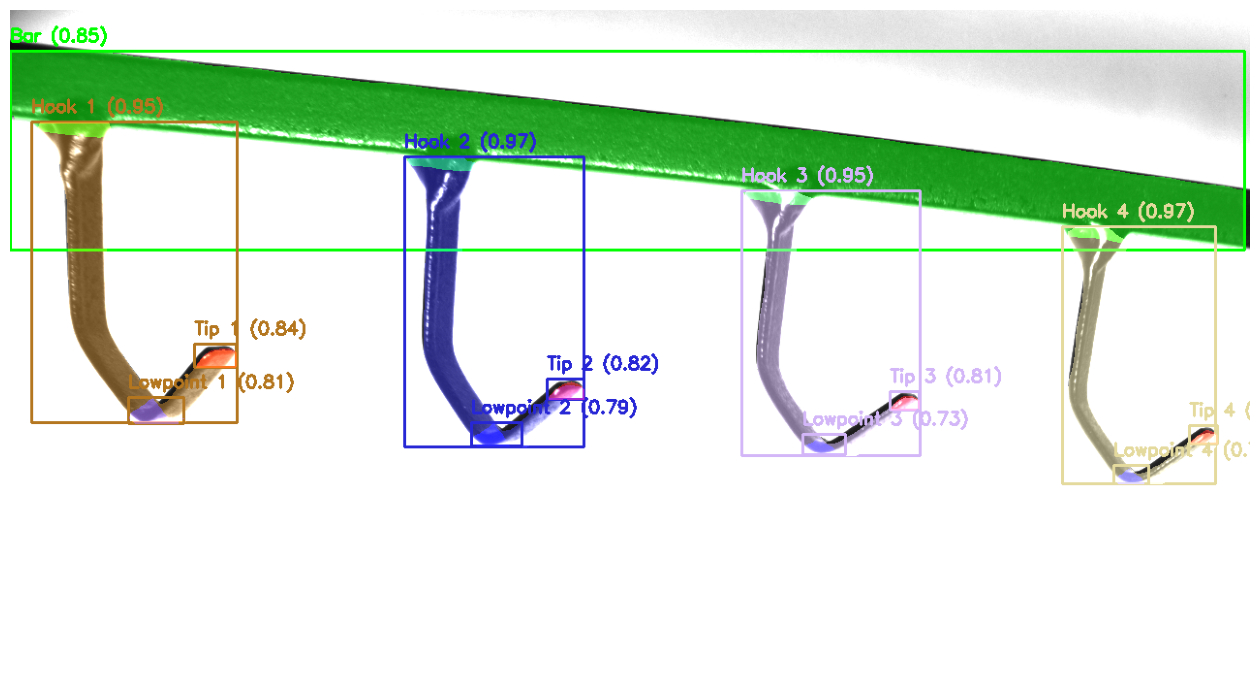

In [415]:
boxes, masks, confs, classes = extract_output(results)
boxes_bar, masks_bar, confs_bar, boxes_hooks, masks_hooks, boxes_tips, masks_tips, boxes_lowpoints, masks_lowpoints, confs_hooks, confs_tips, confs_lowpoints = split_outputs_by_class(boxes, masks, confs, classes)
hooks_dict = create_hook_instances(boxes_hooks, masks_hooks, 
                          boxes_tips, masks_tips, 
                          boxes_lowpoints, masks_lowpoints, 
                          confs_hooks, confs_tips, confs_lowpoints)
bar_dict = create_bar_instance(boxes_bar, masks_bar, confs_bar)

plot_hooks_and_bars(frame_rgb, hooks_dict, bar_dict)

***
**Tracking**

In [406]:
class Tracking:
    def __init__(self, bar_dict, hooks_dict):
        self.hook_track_dict = {}
        self.init_hooks = hooks_dict
        self.init_bar = bar_dict

    def calc_box_midpoint(self, box, round=False):
        x = (box[0] + box[2]) / 2
        y = (box[1] + box[3]) / 2
        if round:
            return np.array([int(x), int(y)])
        else:
            return np.array([x, y])
    
    def calc_dist_and_angle(self, p1, p2):
        distance = math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p2[0])**2)
        angle = math.degrees(math.atan2(p2[1] - p1[1], p2[0] - p1[0]))

        if angle < 0:
            angle += 360

        return distance, angle

    def track(self, hooks_dict):
        for idx, hook_name in enumerate(hooks_dict):
            hook = hooks_dict[hook_name]
            hook_box = hook["hook_box"]
            tip_box = hook["tip_box"]
            lowpoint_box = hook["lowpoint_box"]

            if hook_name not in self.hook_track_dict:
                self.hook_track_dict[hook_name] = {}

            hook_pos_act = calc_box_midpoint(hook_box, round=True)
            tip_pos_act = calc_box_midpoint(tip_box, round=True)
            lowpoint_pos_act = calc_box_midpoint(lowpoint_box, round=True)

            if len(self.hook_track_dict[hook_name]) != 0:
                hook_pos_pre = self.hook_track_dict[hook_name]['xy_hook'][-1]
                tip_pos_pre = self.hook_track_dict[hook_name]['xy_tip'][-1]
                lowpoint_pos_pre = self.hook_track_dict[hook_name]['xy_lowpoint'][-1]

                if len(self.hook_track_dict[hook_name]) >= 2:
                    hook_dist_act, hook_orient_act = self.calc_dist_and_angle(hook_pos_pre, hook_pos_act)
                    tip_dist_act, tip_orient_act = self.calc_dist_and_angle(tip_pos_pre, tip_pos_act)
                    lowpoint_dist_act, lowpoint_orient_act = self.calc_dist_and_angle(lowpoint_pos_pre, lowpoint_pos_act)

            if (len(self.hook_track_dict[hook_name]) != 0) and (hook_pos_act[0] != hook_pos_pre[0]) and (hook_pos_act[1] != hook_pos_pre[1]):
                self.hook_track_dict[hook_name]['xy_hook'].append(hook_pos_act)
                self.hook_track_dict[hook_name]['hook_dist'].append(hook_dist_act)
                self.hook_track_dict[hook_name]['hook_orient'].append(hook_orient_act)

                self.hook_track_dict[hook_name]['xy_tip'].append(tip_pos_act)
                self.hook_track_dict[hook_name]['tip_dist'].append(tip_dist_act)
                self.hook_track_dict[hook_name]['tip_orient'].append(tip_orient_act)

                self.hook_track_dict[hook_name]['xy_lowpoint'].append(lowpoint_pos_act)
                self.hook_track_dict[hook_name]['lowpoint_dist'].append(lowpoint_dist_act)
                self.hook_track_dict[hook_name]['lowpoint_orient'].append(lowpoint_orient_act)

            if (len(self.hook_track_dict[hook_name]) == 0):
                self.hook_track_dict[hook_name]['xy_hook'] = [hook_pos_act]
                self.hook_track_dict[hook_name]['hook_dist'] = []
                self.hook_track_dict[hook_name]['hook_orient'] = []

                self.hook_track_dict[hook_name]['xy_tip'] = [tip_pos_act]
                self.hook_track_dict[hook_name]['tip_dist'] = []
                self.hook_track_dict[hook_name]['tip_orient'] = []

                self.hook_track_dict[hook_name]['xy_lowpoint'] = [lowpoint_pos_act]
                self.hook_track_dict[hook_name]['lowpoint_dist'] = []
                self.hook_track_dict[hook_name]['lowpoint_orient'] = []
    
    def plot(self, act_img=None, show_hooks=True, show_tips=True, show_lowpoints=True):
        plt.figure(figsize=(10, 5))
        plt.imshow(act_img, extent=[0, act_img.shape[1], act_img.shape[0], 0])  # Bild als Hintergrund setzen mit umgekehrter y-Achse

        for hook_key, hook_data in self.hook_track_dict.items():
            xy_hooks = hook_data['xy_hook']
            xy_tips = hook_data['xy_tip']
            xy_lowpoints = hook_data['xy_lowpoint']

            if show_hooks:
                for hook in xy_hooks:
                    plt.plot(hook[0], hook[1], 'ro')
            if show_tips:
                for tip in xy_tips:
                    plt.plot(tip[0], tip[1], 'ro')
            if show_lowpoints:    
                for lowpoint in xy_lowpoints:
                    plt.plot(lowpoint[0], lowpoint[1], 'ro')

        plt.title("Tracking Plot")
        plt.xlim(0, act_img.shape[1])
        plt.ylim(act_img.shape[0], 0)
        plt.show()

In [407]:
tracking = Tracking(bar_dict = None, hooks_dict=hooks_dict)

In [416]:
tracking.track(hooks_dict)

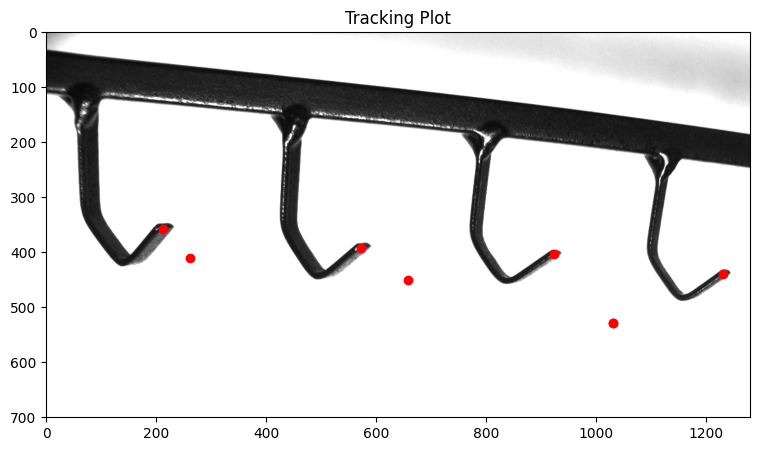

In [417]:
tracking.plot(act_img=frame_rgb, show_hooks=False, show_tips=True, show_lowpoints=False)

In [418]:
print(tracking.hook_track_dict['hook_1'])
print(tracking.hook_track_dict['hook_2'])
print(tracking.hook_track_dict['hook_3'])
print(tracking.hook_track_dict['hook_4'])

{'xy_hook': [array([225, 290]), array([128, 271])], 'hook_dist': [172.7946758439044], 'hook_orient': [191.08256946302964], 'xy_tip': [array([261, 410]), array([212, 357])], 'tip_dist': [153.05554547287727], 'tip_orient': [227.24574256589509], 'xy_lowpoint': [array([201, 435]), array([151, 413])], 'lowpoint_dist': [266.7283262047734], 'lowpoint_orient': [203.74949449286675]}
{'xy_hook': [array([603, 357]), array([499, 301])], 'hook_dist': [223.6515146382872], 'hook_orient': [208.30075576600638], 'xy_tip': [array([658, 450]), array([573, 392])], 'tip_dist': [199.96499693696396], 'tip_orient': [214.30778784471596], 'xy_lowpoint': [array([581, 495]), array([502, 438])], 'lowpoint_dist': [101.67103815738285], 'lowpoint_orient': [215.81116392264124]}
{'xy_hook': [array([963, 434]), array([847, 323])], 'hook_dist': [536.6861280115222], 'hook_orient': [223.73818246111387], 'xy_tip': [array([1031,  528]), array([923, 404])], 'tip_dist': [530.1179114121687], 'tip_orient': [228.94518622903755], '

***
***
**Performance - Zeitmessungen**

**Inferenz Zeitmessung**

In [24]:
num_inference_runs = 100

time_values = []

for inf in range(num_inference_runs):
    start_time = time.perf_counter()
    results = model.predict(source = img_path,
                            device=device,
                            conf = confidence_threshold,
                            iou = 0.7,
                            max_det = max_hooks,
                            visualize = False,
                            classes = [0, 1, 2, 3],
                            retina_masks = True,
                            show_conf=False,
                            show_boxes=False,
                            show_labels=True,
                            save=False,
                            show=False,
                            save_txt=False,
                            save_crop=False,
                            line_width=2,
                            box=False)
    end_time = time.perf_counter()
    time_taken = end_time - start_time
    time_values.append(time_taken)

print(f"Durchschnittlche Inferenzlaufzeit: {sum(time_values)/(len(time_values)):.4f} Sekunden")
print(f"Durchschnittliche FPS: {len(time_values) / (sum(time_values)):.4f}")


image 1/1 /home/mo/YoloV8_InstanceSeg/dataset/image_1735929919.png: 352x640 2 hooks, 2 tips, 2 lowpoints, 6.1ms
Speed: 1.3ms preprocess, 6.1ms inference, 5.4ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 /home/mo/YoloV8_InstanceSeg/dataset/image_1735929919.png: 352x640 2 hooks, 2 tips, 2 lowpoints, 6.1ms
Speed: 1.0ms preprocess, 6.1ms inference, 5.1ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 /home/mo/YoloV8_InstanceSeg/dataset/image_1735929919.png: 352x640 2 hooks, 2 tips, 2 lowpoints, 5.9ms
Speed: 1.0ms preprocess, 5.9ms inference, 5.1ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 /home/mo/YoloV8_InstanceSeg/dataset/image_1735929919.png: 352x640 2 hooks, 2 tips, 2 lowpoints, 5.9ms
Speed: 1.0ms preprocess, 5.9ms inference, 5.1ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 /home/mo/YoloV8_InstanceSeg/dataset/image_1735929919.png: 352x640 2 hooks, 2 tips, 2 lowpoints, 5.9ms
Speed: 1.5ms preprocess, 5.9ms inference, 5.2ms pos

**Postprocessing Zeitmessung**

In [25]:
num_postprocessing_runs = 100

time_values = []

for i in range(num_postprocessing_runs):
    start_time = time.perf_counter()

    boxes, masks, confs, classes = extract_output(results)
    boxes_bar, masks_bar, confs_bar, boxes_hooks, masks_hooks, boxes_tips, masks_tips, boxes_lowpoints, masks_lowpoints, confs_hooks, confs_tips, confs_lowpoints = split_outputs_by_class(boxes, masks, confs, classes)
    hooks_dict = create_hook_instances(boxes_hooks, masks_hooks, boxes_tips, masks_tips, boxes_lowpoints, masks_lowpoints, confs_hooks, confs_tips, confs_lowpoints)
    bar_dict = create_bar_instance(boxes_bar, masks_bar, confs_bar)
    # plot_hooks_and_bars(frame_rgb, hooks_dict, bar_dict)

    end_time = time.perf_counter()
    time_values.append(end_time-start_time)

print(f"Time Postprocessing: {(sum(time_values) / len(time_values)):.4f} sec")
print(f"Durchschnittliche FPS: {len(time_values) / (sum(time_values)):.4f}")

Time Postprocessing: 0.0072 sec
Durchschnittliche FPS: 139.7781


**Inference + Postprocessing Laufzeit**

In [26]:
num_runs = 100

time_values = []

for run in range(num_runs):
    start_time = time.perf_counter()

    results = model.predict(source = img_path,
                            device=device,
                            conf = confidence_threshold,
                            iou = 0.7,
                            max_det = max_hooks,
                            visualize = False,
                            classes = [0, 1, 2, 3],
                            retina_masks = True,
                            show_conf=False,
                            show_boxes=False,
                            show_labels=True,
                            save=False,
                            show=False,
                            save_txt=False,
                            save_crop=False,
                            line_width=2,
                            box=False)
    
    boxes, masks, confs, classes = extract_output(results)
    boxes_bar, masks_bar, confs_bar, boxes_hooks, masks_hooks, boxes_tips, masks_tips, boxes_lowpoints, masks_lowpoints, confs_hooks, confs_tips, confs_lowpoints = split_outputs_by_class(boxes, masks, confs, classes)
    hooks_dict = create_hook_instances(boxes_hooks, masks_hooks, boxes_tips, masks_tips, boxes_lowpoints, masks_lowpoints, confs_hooks, confs_tips, confs_lowpoints)
    bar_dict = create_bar_instance(boxes_bar, masks_bar, confs_bar)
    # plot_hooks_and_bars(frame_rgb, hooks_dict, bar_dict)

    end_time = time.perf_counter()
    time_values.append((end_time - start_time))

print(f"Durchschnittliche Laufzeit Inferenz + Postproccesing: {(sum(time_values) / len(time_values)):.4f} sec")
print(f"Durchschnittliche FPS: {len(time_values) / (sum(time_values)):.4f}")


image 1/1 /home/mo/YoloV8_InstanceSeg/dataset/image_1735929919.png: 352x640 2 hooks, 2 tips, 2 lowpoints, 6.9ms
Speed: 1.1ms preprocess, 6.9ms inference, 5.4ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 /home/mo/YoloV8_InstanceSeg/dataset/image_1735929919.png: 352x640 2 hooks, 2 tips, 2 lowpoints, 6.6ms
Speed: 1.4ms preprocess, 6.6ms inference, 5.2ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 /home/mo/YoloV8_InstanceSeg/dataset/image_1735929919.png: 352x640 2 hooks, 2 tips, 2 lowpoints, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 5.2ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 /home/mo/YoloV8_InstanceSeg/dataset/image_1735929919.png: 352x640 2 hooks, 2 tips, 2 lowpoints, 6.6ms
Speed: 1.1ms preprocess, 6.6ms inference, 5.3ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 /home/mo/YoloV8_InstanceSeg/dataset/image_1735929919.png: 352x640 2 hooks, 2 tips, 2 lowpoints, 6.1ms
Speed: 1.3ms preprocess, 6.1ms inference, 5.0ms pos

***
***
**Alte Plot-Funktion ohne Instanzen**

In [48]:
def annotate_frame(frame, results):
    # Konvertierung in RGB nur einmal
    annotated_frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)

    class_colors = {
        0: (255, 0, 0),  # bar -> rot
        1: (0, 255, 0),  # hook -> grün
        2: (0, 0, 255),  # tip -> blau
        3: (255, 255, 0),  # lowpoint -> cyan
    }

    labelnames = ["bar", "hook", "tip", "lowpoint"]

    results = results[0]
    class_counters = {label: 0 for label in range(len(labelnames))}

    # Optimierung der Bounding-Box-Zeichnung
    if results:
        if results.boxes is not None:
            for box in results.boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])  # Koordinaten
                conf = box.conf[0]                      # Konfidenzwert
                label = int(box.cls[0])                 # Klassenindex
                color = class_colors.get(label, (255, 255, 255))

                # Instanzen
                class_counters[label] += 1
                instance_id = class_counters[label]  # Eindeutige Nummer für diese Instanz
                instance_label = f"{labelnames[label]}_{instance_id}"

                # Rechteck und Text zeichnen
                cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), color, 2)
                cv2.putText(annotated_frame, f"{instance_label} ({conf:.2f})",
                        (x1, max(y1 - 10, 0)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    # Optimierung der Maskenverarbeitung
    if results and results.masks is not None:
        masks = results.masks.data.cpu().numpy()  # Alle Masken auf einmal holen
        combined_mask = np.zeros_like(annotated_frame, dtype=np.uint8)

        for i, mask in enumerate(masks):
            mask = (mask > 0.5).astype(np.uint8)  # Binärmaske
            label = int(results.boxes.cls[i])     # Klasse
            color = class_colors.get(label, (255, 255, 255))

            # Farbige Maske erstellen
            for c in range(3):
                combined_mask[:, :, c] += mask * color[c]

        # Kombiniere Masken mit Originalbild
        annotated_frame = cv2.addWeighted(annotated_frame, 1.0, combined_mask, 0.5, 0)

    return annotated_frame

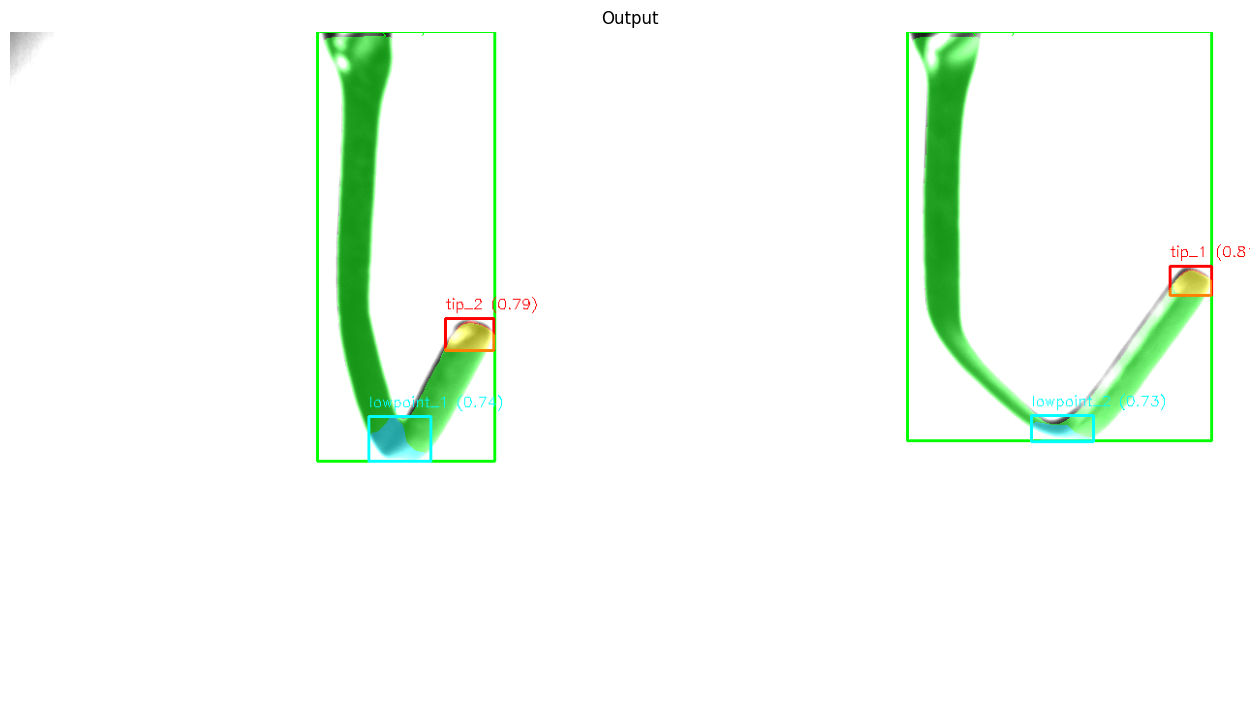

In [49]:
annotated_frame = annotate_frame(frame, results)

plt.figure(figsize=(16, 16))
plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Output")
plt.show()